# AB TEST ANALYSIS
[link](https://www.kaggle.com/code/sergylog/ab-test-data-analysis)

## IMPORT PACKAGES


In [2]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro


## IMPORT FILE


In [3]:
df = pd.read_csv("../ABtesting/AB_Test_Results.csv")
df.head(10)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [5]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [6]:
#unique values for each variable
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

In [7]:
#describe
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


we can see that the number of records is higher then the number of unique ids
this means that the same user can be included more than once in the analysis

In [8]:
#let's dig into users and understand if they can appear in both groups
double_variant_count = df.groupby('USER_ID')['VARIANT_NAME'].nunique().value_counts()
double_variant_count

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

as we were assuming before, some users are considered twice, or even more, in the same sample.

In [9]:
#consider only users that appears in only one group
unique_users = (df.groupby('USER_ID')['VARIANT_NAME'].nunique()==1)
unique_users

USER_ID
2         True
3        False
4         True
5         True
6         True
         ...  
9993      True
9995      True
9996     False
9998      True
10000    False
Name: VARIANT_NAME, Length: 6324, dtype: bool

In [10]:
#take only the ids of users that appears in just 1 group
unique_users = unique_users[unique_users]
unique_users

USER_ID
2       True
4       True
5       True
6       True
9       True
        ... 
9990    True
9992    True
9993    True
9995    True
9998    True
Name: VARIANT_NAME, Length: 4783, dtype: bool

In [11]:
# leave only records with users that appears in only on group (they can appear even more time in the same group)
df = df[df['USER_ID'].isin(unique_users.index)]
df.nunique()

USER_ID         4783
VARIANT_NAME       2
REVENUE           70
dtype: int64

## DATA DISTRIBUTION

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

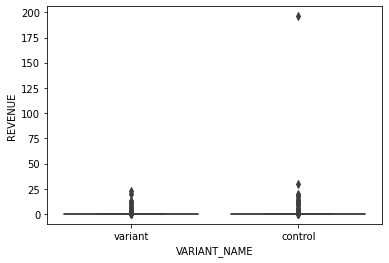

In [12]:
sns.boxplot(x='VARIANT_NAME', y='REVENUE', data=df)


looks lik there is a big outlier (it may b removed)

In [13]:
#print top 10 highest values of revenues
df.sort_values(by='REVENUE', ascending=False).iloc[:10]


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01
8168,2166,control,29.32
2482,7356,variant,23.04
6412,1053,control,20.07
5217,3684,variant,19.47
5530,282,control,18.56
758,4445,control,17.05
4031,2059,control,14.24
9019,1973,control,14.07
4561,4966,variant,12.99


In [14]:
#let's see if user id 3342 has other events
df[df['USER_ID']==3342]


,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


In [15]:
#no other events --> remove outlier
df = df[df['USER_ID']!=3342]


<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

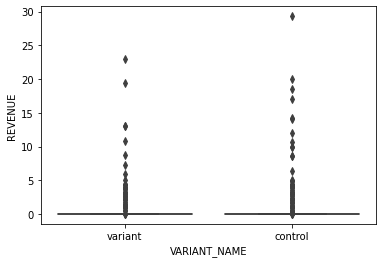

In [16]:
#plot again data
sns.boxplot( x = 'VARIANT_NAME', y = 'REVENUE', data = df)

<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

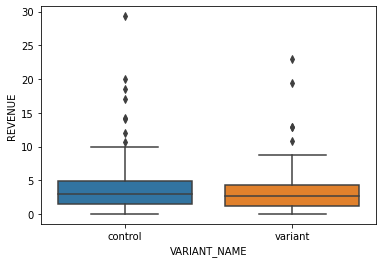

In [17]:
#plot only data with revenues > 0
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])

most of the users has no purchases in particular...


In [18]:
pct_purchases_control = "{:.3%}".format(len(df.loc[(df['VARIANT_NAME']=='control') & (df['REVENUE']>0)])/len(df.loc[df['VARIANT_NAME']=='control']))
pct_purchases_control

'1.752%'

In [19]:
pct_purchases_variant = "{:.3%}".format(len(df.loc[(df['VARIANT_NAME']=='variant') & (df['REVENUE']>0)])/len(df.loc[df['VARIANT_NAME']=='variant']))
pct_purchases_variant

'1.413%'

let's see if there are users that have both no purchase and purchase


In [20]:
#user ids with revenues > 0
ids_with_revenues = df.loc[df['REVENUE'] > 0, 'USER_ID'].values

In [21]:
#let's use the ids extracted above to see if some of them have even 0 revenues events
df.loc[(df['REVENUE'] == 0) & df['USER_ID'].isin(ids_with_revenues)].count()


USER_ID         52
VARIANT_NAME    52
REVENUE         52
dtype: int64

52 users have events with both positive and null events.
Let's make the assumption that the records are user visits to the service, and the experimental unit is users.
--> Group by user and sum its revenues

In [22]:
df = df.groupby(by=['USER_ID','VARIANT_NAME']).sum().reset_index()
df


,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,4,variant,0.0
2,5,variant,0.0
3,6,variant,0.0
4,9,variant,0.0
...,...,...,...
4777,9990,variant,0.0
4778,9992,control,0.0
4779,9993,control,0.0
4780,9995,variant,0.0


<AxesSubplot:xlabel='VARIANT_NAME', ylabel='REVENUE'>

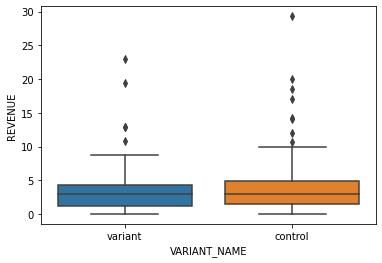

In [23]:
#plot only data with revenues > 0
sns.boxplot(x = 'VARIANT_NAME', y = 'REVENUE', data = df[df['REVENUE'] > 0])
#quantile have increased compared to before

deep dive on revenue distribution


<AxesSubplot:xlabel='REVENUE', ylabel='Count'>

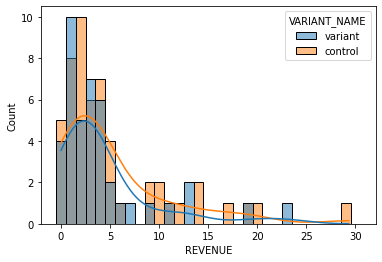

In [44]:
#distribution of revenues of all users based on the group (considering only rev>0)
sns.histplot(data=df[df['REVENUE']>0], x='REVENUE',hue='VARIANT_NAME', discrete=True, kde=True)

not visible a clear distinction in term of behaviour from the 2 groups
The main highlight is that control group tend to do transactions with higher values

## STATISTICAL ANALYSIS

In [45]:
#check data distribution (even if looking at past data we see that it is not)
shapiro(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'])


ShapiroResult(statistic=0.06145977973937988, pvalue=0.0)

The null hypothesis regarding the normal distribution of the data is rejected

### Mann-Withney Test
Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [46]:
(df['REVENUE'] == 0).value_counts()

True     4687
False      95
Name: REVENUE, dtype: int64

In [47]:
#check on data of all the users of the df
mannwhitneyu(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'], df.loc[df.VARIANT_NAME == 'control', 'REVENUE'])

MannwhitneyuResult(statistic=2845109.0, pvalue=0.24799555106821947)

In [49]:
#check on data of only users who pay
mannwhitneyu(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'],
             df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'])


MannwhitneyuResult(statistic=1029.0, pvalue=0.5314192217084708)

### BOOTSTRAP
In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.
Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [51]:
#functions
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [52]:
#generate samples for all users
control = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'control', 'REVENUE'].values, 10000)
variant = get_bootstrap_samples(df.loc[df.VARIANT_NAME == 'variant', 'REVENUE'].values, 10000)

In [53]:
#generate samples for paying users
control_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'control') & (df.REVENUE > 0), 'REVENUE'].values, 10000)
variant_paid = get_bootstrap_samples(df.loc[(df.VARIANT_NAME == 'variant') & (df.REVENUE > 0), 'REVENUE'].values, 10000)


look at distribution of means in the AB test group

Text(0.5, 1.0, 'Sample mean distribution for all users')

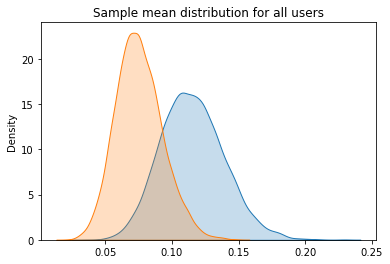

In [55]:
#all users
f, ax = plt.subplots()
sns.kdeplot(np.mean(control, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

Text(0.5, 1.0, 'Sample mean distribution for paying users')

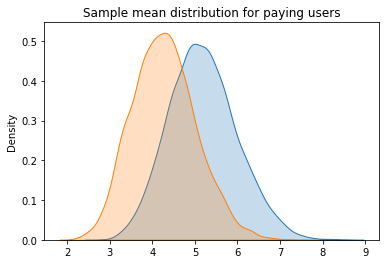

In [56]:
#paying users
f, ax = plt.subplots()
sns.kdeplot(np.mean(control_paid, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_paid, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')


## CONCLUSIONS
Conclusions 
In order to draw conclusions about changes between ab test groups, the following changes were first made to the data:

Users with two ab test groups were excluded in order to make the effect of the changes more pronounced User_id=3342 was excluded, because in conditions of limited information it is a strong outlier in the received sample Users are taken as the experimental unit, and then the data is grouped by each user and revenue and summed over each to get one record per user Despite the fact that the revenue in the test group decreased significantly, there were no statistically significant changes between the ab test groups, both among all users and among only the paying audience. For a deeper analysis, the data of the A / A test and further study of the power of the criteria will be useful.

